<a href="https://colab.research.google.com/github/unknown-jun/NLP_study/blob/main/Self_Implement/BERT_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT word embedding

- [출처](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#33-creating-word-and-sentence-vectors-from-hidden-states)

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

import logging
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 1. Input Formatting
BERT는 특정한 구조를 가진 input 데이터를 필요로 하는 모델이기 때문에 다음과 같은 input들이 필요하다.
1. A special token `[SEP]`: 문장의 끝을 표시하거나 두 문장 사이를 나누는 역할을 한다.
2. A special token `[CLS]`: 문장의 시작 지점에 나타나며 Classification task에 사용되지만 어떠한 task든 간에 있어야 한다.
3. BERT의 양식에 맞는 Token
4. BERT의 tokenizer으로 부터 나온 Token ID
5. Mask ID는 Sequence의 어떤 요소가 토큰인지 padding 요소인지를 나타낸다.
6. Segment ID는 다른 문장들을 구분하기 위해 사용된다.
7. Positional Embeddings은 문장 내에서 토큰의 위치를 알려주기 위해 사용된다.

`transformers`는 이 모든 요소를 쉽게 처리해준다.  
그러나 이번 노트북에서는 BERT에 대한 원리를 배우기 위함이므로 이 모든 과정을 직접 구현하게 될 것이다.

## 1.1 Special Tokens
BERT는 하나 혹은 두개의 문장을 input으로 받아들일수 있으며 special token인 `[SEP]`는 문장들을 구분하는 역할을 한다. `[CLS]` token은 항상 문장 맨 처음에 등장하며 이는 classification task에 쓰인다.

그러나 만약 한 개의 문장만을 가지고 있거나, BERT를 classificaion에 쓰지 않더라도 위의 두개의 token은 항상 필요로 한다. BERT는 두 token을 가지고 학습했으므로 사용 시에도 두 token을 받을 것으로 기대하며 작동한다.

- 2 Sentence Input:  
  `[CLS] The man went to the store. [SEP] He bought a gallon of milk`
- 1 Sentence Input:  
`[CLS] The man went to the store. [SEP]`

## 1.2 Tokenization
BERT는 고유한 tokenizer를 가진다. 아래는 한 문장내에서 tokenizer가 작동하는 지에 대한 내용이다.

In [3]:
text = "Here is the sentence I want embeddings for"
marked_text = '[CLS] ' + text + ' [SEP]'

# BERT tokenizer를 이용하여 tokenize
tokenized_text = tokenizer.tokenize(marked_text)

tokenized_text

['[CLS]',
 'here',
 'is',
 'the',
 'sentence',
 'i',
 'want',
 'em',
 '##bed',
 '##ding',
 '##s',
 'for',
 '[SEP]']

BERT의 word embedding은 다음과 같이 단어를 분리하였다.  
`['em', '##bed', '##ding', '##s']`

원래의 문장은 더 작은 subwords와 문자로 분리된 것을 알 수 있다.subword 앞의 ##는 BERT tokenizer의 방식인데 이는 문자나 subword가 더 큰 단어에 속하는지 다른 subword에 속하는지를 알려주는 기호다.
예를 들어 '##bed' token은 'bed' token와는 별개의 token으로의 특성을 가진다. 첫번째 token은 더 큰 단어 안에서 'bed'가 나타날 때 마다 사용되며, 후자는 'bed' 그 자체의 독립적인 뜻을 가진 token으로써 '사람이 자기위해 사용되는 물건'이라는 의미를 가진다.

왜 이런 방식으로 BERT tokenizer가 작동하는가? 이는 BERT tokenizer가 WordPiece 모델의 방식을 차용했기 때문이다. 이 모델은 탐욕스럽게(greedily) 언어 데이터에 적합한 독립적인 문자, subwords, 단어를 고정된 크기의 vocabulary로 생성한다. 

BERT tokenizer 모델의 어휘는 30,000개으로 제한되기 때문에, WordPiece 모델은 모든 영어 character들과 모델이 영어 corpus에서 학습해 온 30,000개의 단어와 subword를 포함하는 단어를 생성한다. 이 vocabulary는 다음과 같은 네 가지 요소를 포함한다.

1. 모든 단어
2. 단어 앞이나 독립적으로 발생한 Subword("embedding"과 "go get em" 안의 "em"은 독립형 sequence로써 동일한 벡터로 할당된다.)
3. 단어 앞에 속하지 않은 Subword, 이 경우는 앞에 ##를 붙여 구분한다.
4. 개별적인 character

이 모델에 단어를 tokenize 하기 위해선 tokenizer가 첫번째로 하는 일은 전체 단어가 vocabulary(단어 사전)에 속하는지를 체크하는 것이다. 만약 아니라면 tokenizer는 단어를 vocabulary에 있는 가능한 가장 큰 subword로 쪼개려고 시도하고 이를 실패할 경우 마지막 수단으로 단어를 개별적인 chracter로 만든다. 이로 인하여 항상 단어를 최소한의 개별 문자의 모음으로 나타낼 수 있다.

vocabulary 단어로 'OOV'나 'UNK'를 이용하여 모든 단어를 할당하는 방식은 vocabulary에 속하지 않는 단어에 대한 임베딩이 어렵지만 WordPiece 방식은 vocabulary에 속하지 않더라도 이를 subword나 character token으로 임베딩 할 수 있다. 이처럼 "embedding"이나 vocabulary에 속하지 않는 단어를 Unknown token에 할당하는 것보다 subword token과 같이 ['em', '##bed', '##ding', '##s']처럼 분할함으로써 더 많은 문맥적 의미를 포함시킬 수 있다. 이러한 방식은 subword 임베딩 벡터를 평균화하여 원래 단어와 비슷한 벡터를 생성할 수 있다.  

아래는 BERT tokenizer가 가지고 있는 token들의 예시이다. Token 앞에 ##로 시작하는 것은 독립적인 character거나 subword들이다.

In [7]:
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

text를 token들로 나눈 후에는 문장을 string의 리스트에서 vocabulary의 리스트로 변환하여야 한다.

아래는 다른 의미를 가진 'bank'를 포함한 두개의 문장을 임베딩한 결과이다.

In [9]:
# 중의적인 의미를 가진 bank를 포함한 두개의 문장의 정의
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# special token을 추가한다.
marked_text = "[CLS] " + text + " [SEP]"

# 문장을 token으로 분리한다.
tokenized_text = tokenizer.tokenize(marked_text)

# vocabulary의 index를 token string에 맵핑한다.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# 단어와 단어가 가진 index들을 print
for tup in zip(tokenized_text, indexed_tokens):
  print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


## 1.3 Segment ID
BERT는 1과 0을 사용하여 두 문장을 구별하며 이를 통해 문장 쌍을 훈련하고 예측한다. 즉, tokenize할 문장은 반드시 0이나 1로 구분되어져야 한다. 그러나 이번 예제에서는 하나의 문장만을 사용할 것이기 때문에 input으로 1을 사용한다. 만약 두개의 문장을 tokenize하고 싶다면 '[SEP]'를 포함한 첫번째 문장을 0으로, 그 뒤의 문장을 1로 할당해야 한다.

In [11]:
# 22개의 token들을 sentence 번호 1로 할당한다.
segment_ids = [1] * len(tokenized_text)
segment_ids

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# 2. Extracting Embeddings

## 2.1 Running BERT on our text
다음으로는 data를 torch의 tensor로 변환하는 작업이 필요하다.BERT Pytorch는 Python의 list 대신에 torch의 tensor형을 요구한다. 다음과 같은 코드를 통해 문서의 형태를 건들지 않으면서 list형을 변환할 수 있다.

In [13]:
# Input값을 Pytorch의 tensor형으로 변환
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensor = torch.tensor([segment_ids])

`from_pretrained`를 호출함으로써 인터넷에 있는 모델을 호출할 수 있다. `bert-base-uncased`를 로드할 때, logging를 사용하여 모델의 정의에 대하여 확인이 가능하다. 모델은 12개의 layer를 사용한 neural network다. layer와 그의 기능에 대한 내용은 이번 post의 범위를 뛰어넘으므로 이 글에서는 설명하지 않는다.

`model.eval()`을 이용하여 모델을 훈련 모드가 아닌 평가 모드로 전환한다. 평가 모드로 전환함에 따라 dropout 규제를 사용하지 않도록 한다.

In [14]:
# 사전 훈련 모델을 로드한다.
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # 모든 은닉층을 출력할지에 대한 여부
                                  )

# evaluate 모델로 전환함에 따라 순전파만을 사용하게 된다.
model.eval()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

다음으로, 우리의 예제 text를 BERT를 이용하여 평가하고 network의 은닉층을 호출해보자  
*Side Note: 아래의 `torch.no_grad()`은 계산 그래프를 구축하지 않음을 의미한다(여기선 역전파를 사용하지 않기 때문에). 이로 인하여 메모리 소모를 줄일 수 있으며 속도를 약간 향상 시킬 수 있다.*

In [15]:
# text를 BERT에 입력한다.
# 그리고 12개의 레이어의 은닉층의 정보를 수집한다.
with torch.no_grad():

  outputs = model(tokens_tensor, segments_tensor)
  hidden_states = outputs[2]  # outputs에 'last_hidden_state', 'pooler_outputs', 'hidden_states'를 포함하고 있다.

## 2.2 Understaning the Output
앞서 hidden_states 객체에 저장한 BERT에서 나온 모든 은닉층은 이해하기 어려워 보인다. 이 객체는 아래의 순서대로 4개의 차원으로 구성되어 있다.

1. 총 layer의 수(13 layers)
2. 총 batch의 수(1 sentence)
3. 단어나 토큰의 수(예제에서는 22 tokens)
4. 은닉층의 unit 수/ feature의 수(768 feature)

우리는 앞서 BERT 모델이 총 12개의 레이어로 구성되어 있다고 말했다. 하지만 여기서는 13개의 레이어로 구성되어 있다고 설명하고 있다. 이는 첫번째 레이어는 input embedding layer이기 때문이다. 

단 한개의 문장을 표현하기 위해 사용된 unique 값은 총 219648개이다 (13 x 1 x 22 x 768)
 

두번째 차원인 batch의 size는 한번에 여러 문장을 모델에 입력할 때 사용된다. 이번 예제에서는 단 하나의 문장이 쓰였다.(batch_size= 1)

In [20]:
print("Number of layers: ", len(hidden_states), " (initial embeddings + 12 BERT layers)")
layer_i = 0

print("Number of batches: ", len(hidden_states[layer_i]))
batch_i = 0

print("Number of tokens: ", len(hidden_states[layer_i][batch_i]))
token_i = 0

print('Number of hidden units: ', len(hidden_states[layer_i][batch_i][token_i]))

Number of layers:  13  (initial embeddings + 12 BERT layers)
Number of batches:  1
Number of tokens:  22
Number of hidden units:  768


주어진 레이어와 토큰에 대한 값의 범위를 살펴봤을 때, 몇몇을 제외하고는 모든 레이어와 토큰에 대해 작은 값(-2~2)을 분포를 가지고 있음을 알 수 있다.

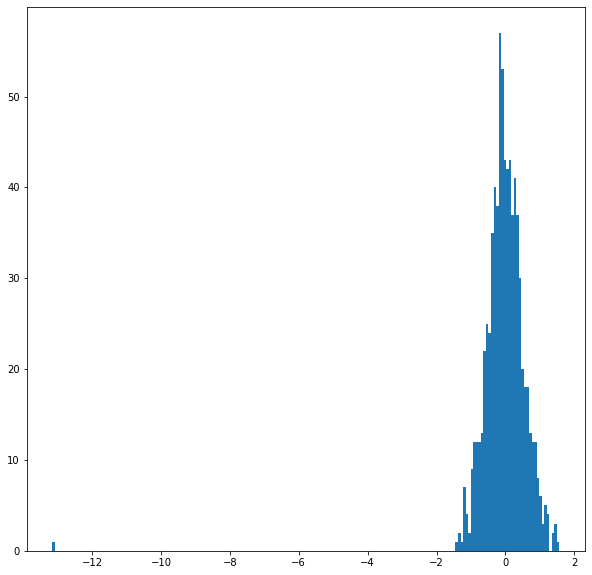

In [21]:
# 예제의 문장에서의 5번째 토큰을 살펴보기 위해 
# layer 5를 선택하여 그것에 대한 feature들을 가져옴
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

plt.figure(figsize=(10,10))
plt.hist(vec, bins=200);

layer별로 값을 그룹핑 하는 것도 좋지만, 이 글에서의 목적인 word_embedding을 위하여 token별로 그룹핑하기로 하자

- 현재 차원:  
`[# layers, # batches, # tokens, # features]`

- 목적에 맞게 변형할 차원:  
`[# tokens, # layers, #features]`

Pytorch의 `permute`함수를 사용하면 tensor의 차원을 쉽게 변형할 수 있다.  
그러나 현재 데이터 타입은 tensor가 아니다.

In [22]:
# hidden_state는 자체는 Python의 list
print('       Type of hidden_sates: ', type(hidden_states))

# 각 layer 안은 torch의 tensor 형태임
print('Tensor shape for each layer: ', hidden_states[0].size())

       Type of hidden_sates:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


하나의 tensor로 만들기 위해 layer들을 합친다.

In [23]:
# 모든 layer들을 합치기 위해 'stack'을 사용한다.
# stack은 하나의 새로운 차원의 tensor를 생성한다.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

필요하지 않은 batch 차원을 제거한다.

In [24]:
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

`permute`을 사용하여 텐서의 차원을 쉽게 재배열 할 수 있다.  
이를 이용하여 'layers'와 'tokens'의 순서를 바꾼다.

In [25]:
# 차원 0과 차원 1을 바꾼다.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

## 2.3 Creating word and sentence vectors from hidden states
이제, 은닉층을 가지고 무엇을 할 수 있을까? 우리는 각 token에 대한 개별 vector나 전체 문장의 단일 vector 표현을 얻고 싶지만, 입력의 각 토큰에 대해 각각 768 크기의 13개의 개별 벡터가 존재한다.

개별 벡터를 얻기 위해서 몇몇 layer 벡터들을 합쳐야 한다. 그러면 어떤 layer 혹은 layer의 조합이 최상의 결과를 낼 수 있을까?

아쉽게도 그에 대한 답은 없다. 하지만 몇가지 합리적인 접근 방식이 있다. 아래는 그에 대한 몇가지 유용한 방법이다.


### Word vectors
두가지 방법으로 단어벡터를 만들어 보자  
먼저 마지막 4개의 layer를 연결하여(concatenate) 토큰 당 단일 벡터를 제공한다. 각 벡터의 길이는 `4 x 768 = 3,072`다.

In [32]:
# [22 x 3,072]의 형태를 가진 token vector를 저장한다.
token_vecs_cat = []

# token_embedding은 [22 x 13 x 768]의 tensor이다.

# token_embeddings의 token 레이어에 대해
for token in token_embeddings:

  # token 레이어는 [12 x 768] tensor다.
  # 마지막 4개의 레이어에서 vector들을 꺼내 concatenate한다.
  # 각 layer vector는 768 벡터다. 그렇기 때문에 'cat_vec'의 길이는 3,072다.

  cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

  token_vecs_cat.append(cat_vec)

print('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


다른 방법으로는 마지막 4개의 layer들을 합쳐(summing) 단어 벡터를 만드는 것이다.

In [33]:
# [22 x 768]의 shape을 가진 token 벡터를 저장하기 위한 초기 객체
token_vecs_sum = []

# token_embeddings는 [22 x 12 x 768]의 tensor

# token_embeddings의 token 레이어에 대해
for token in token_embeddings:

  # 마지막 4개의 layer를 합친다.(sum)
  sum_vec = torch.sum(token[-4:], dim=0)
  token_vecs_sum.append(sum_vec)

print('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


### Sentence vectors

전체 문장에 대한 단일 벡터를 얻기위한 여러 접근 방식이 있지만 가장 간단한 방법은 단일 768크기의 벡터를 생성하는 각 토큰의 두번째에서 마지막 은닉층 레이어를 평균내는 것이다.

In [34]:
# hidden_states는 [13 x 1 x 22 x 768]의 shape

# token_vecs는 [22 x 768]의 shape을 가진다.
token_vecs = hidden_states[-2][0]

# 모든 22개의 token 벡터들의 평균을 계산한다.
sentence_embedding = torch.mean(token_vecs, dim=0)

print("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


## 2.4 Confirming contextually dependent vectors
실제로 이러한 벡터들이 문맥적으로 독립적인 값을 가지는 지 확인하기 위하여 예시 문장에서 각 'bank'에 대한 차이를 살펴보기로 하자

“After stealing money from the **bank vault**, the **bank robber** was seen fishing on the Mississippi **river bank**.”

예제 문장에서 "bank"이라는 단어의 세 가지 예시의 index를 찾아보자.

In [35]:
for i, token_str in enumerate(tokenized_text):
  print(i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


분석을 위해 마지막 4개의 layer를 합친 단어 벡터를 사용해보자.  
이 벡터를 출력하여 다음과 같이 서로 비교해볼 수 있다.

In [36]:
print('First 5 vectors values for each instance of "bank".\n')
print('bank vault   ', str(token_vecs_sum[6][:5]))
print('bank robber  ', str(token_vecs_sum[10][:5]))
print('river bank   ', str(token_vecs_sum[19][:5]))

First 5 vectors values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


In [38]:
from scipy.spatial.distance import cosine

# 단어 bank 사이의 cosine similarity를 계산한다.
# 'bank robber' vs 'river bank' (다른 의미)
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# "bank robber" vs "bank vault"  (같은 의미)
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69
